# Wasserstein GAN Implementation

[Video Explanation 1](https://www.youtube.com/watch?v=QJOEmwvnmTM&list=PLreN7oedDl4dkmswwdffJDsb0Rexq2FTq&index=22) \
[Video Explanation 2](https://youtu.be/pG0QZ7OddX4?si=8aGnSOWCCZSXj-Kh) \
[Wikipedia page](https://en.wikipedia.org/wiki/Wasserstein_GAN) \
[WassersteinGAN Paper](https://arxiv.org/pdf/1701.07875.pdf) \
[WassersteinGAN Read-Through](https://www.alexirpan.com/2017/02/22/wasserstein-gan.html) \
[Improving WGAN](https://arxiv.org/pdf/1704.00028.pdf) \
[Github guide](https://github.com/henry32144/wgan-gp-tensorflow/blob/master/WGAN-GP-celeb64.ipynb)

[Image Denoising With Generative Adversarial Networks](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9069260)

In [1]:
# setting up paths
from sys import path, stdout
import os
from os import environ
import time
import math
from __future__ import division
from IPython.display import clear_output

path.append("/home/leandrosantos/IC-AutoEncoder/")
path.append("/home/leandrosantos/IC-AutoEncoder/modules/")
path.append("/home/leandrosantos/IC-AutoEncoder/src/modules/")

# setting device
environ["CUDA_VISIBLE_DEVICES"] = "1"

# setting seeds for reproduce
import tensorflow as tf
import random as rd
import numpy as np

seed = 6756
rd.seed(seed)
tf.random.set_seed(seed)

2023-10-28 21:29:12.736312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 21:29:14.169129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-28 21:29:14.169206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-28 21:29:14.169216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# importing libraries

from tensorflow.keras import Sequential

from modules.misc import ssim_metric
from modules.ImageMetrics.metrics import three_ssim, psnrb

import keras_tuner as kt

from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

# Dataset

In [3]:
# Fetching dataset

from modules.DataMod import DataSet
import cupy

cifar, tiny, noised_dataset = DataSet(), DataSet(), DataSet()

cifar.load_rafael_cifar_10_noise_data()
tiny.load_rafael_tinyImagenet_64x64_noise_data()
print("Cifar and tiny loaded.")

noised_dataset.load_cifar_and_tiny(cifar, tiny, shuffle=True)
noised_dataset.add_gaussian_noise(dist_normal = 0.05) # adds gaussian noise
print("Dataset created.")

cupy.get_default_memory_pool().free_all_blocks()
cupy.get_default_pinned_memory_pool().free_all_blocks()

del cifar, tiny

Cifar and tiny loaded.
Dataset created.


In [4]:
# normalize dataset
noised_dataset.x_train = (noised_dataset.x_train - 127.5)/127.5
noised_dataset.y_train = (noised_dataset.y_train - 127.5)/127.5
noised_dataset.x_test = (noised_dataset.x_test - 127.5)/127.5
noised_dataset.y_test = (noised_dataset.y_test - 127.5)/127.5

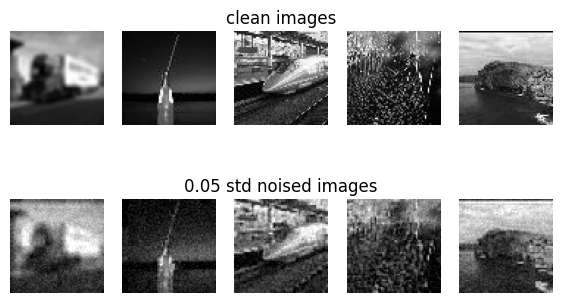

In [5]:
# seeing the noised datasets 

from matplotlib import pyplot as plt

plt.figure(figsize=(7, 4))
columns = 5
rows = 2

magic_number = [rd.randint(0, noised_dataset.x_train.shape[0]-1) for x in range(columns)]

plt.subplot(rows, columns, 3)
plt.title("clean images")
plt.subplot(rows, columns, 8)
plt.title("0.05 std noised images")

for idx in range(columns):
    plt.subplot(rows, columns, idx+1)
    plt.imshow(np.clip(noised_dataset.y_train[magic_number[idx]]*0.5 + 0.5, 0, 1), cmap="gray")
    plt.axis("off")
    plt.subplot(rows, columns, idx+columns+1)
    plt.imshow(np.clip(noised_dataset.x_train[magic_number[idx]]*0.5 + 0.5, 0, 1), cmap="gray")
    plt.axis("off")

# Model Implementation

## Hyperparameters

In [6]:
MODEL_NAME = 'WGAN'

OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

TARGET_IMG_SIZE = 64 # output image size

BATCH_SIZE = 120
NOISE_DIM = TARGET_IMG_SIZE*TARGET_IMG_SIZE
LAMBDA = 10 # For gradient penalty

EPOCHS = 500
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 1 # Save checkpoint at every n epoch

N_CRITIC = 5 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.0000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

2023-10-28 21:29:47.736353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 21:29:47.741177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10379 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


# Generator

In [7]:
def generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z = Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

## Discriminator

In [8]:
def discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 1)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [9]:
generator = generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 8192)              33554432  
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        4194304   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0     

In [10]:
discriminator = discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0   

In [11]:
# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [12]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 360 restored!!


In [13]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, show=False):
    '''
        Generate images and plot it.
    '''
    rows = 2*subplot[0]
    columns = subplot[1]
    
    predictions = model.predict(test_input, verbose=0) 
    fig, axs = plt.subplots(rows, columns, figsize=figure_size, gridspec_kw={'width_ratios':[1 for x in range(columns)], 'height_ratios':[1 for x in range(rows)]})
    
    padding = 0
    for row in range(rows):
        for column in range(columns):
            i = column+padding
            if row%2 == 0:
                axs[row, column].imshow(np.clip(predictions[i]*0.5 + 0.5, 0, 1), cmap='gray')
                
            else:
                axs[row, column].imshow(np.clip(test_input[0][i].reshape(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 1).astype('float32')*0.5 + 0.5, 0, 1), cmap='gray')
            axs[row, column].axis('off')
            
        if row%2 != 0:
            padding += 6
    
    fig.tight_layout()
            
    del fig, axs
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()

2023-10-28 21:29:50.826720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201


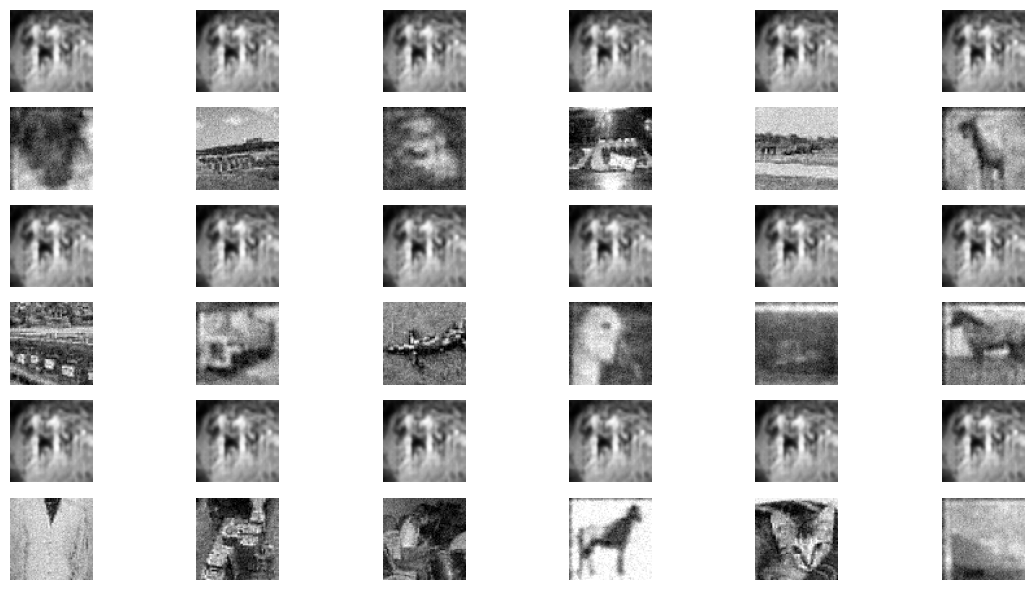

In [14]:
num_examples_to_generate = 18

# change y_test for x_test
magic_number = [rd.randint(0, noised_dataset.x_test.shape[0]-1) for x in range(num_examples_to_generate)]

sample = np.zeros([num_examples_to_generate, NOISE_DIM])

for idx, idx_img in enumerate(magic_number):
    sample[idx] = noised_dataset.x_test[idx_img].reshape((4096))

generate_and_save_images(generator, 0, [sample], figure_size=(12,6), subplot=(3,6), save=False, show=True)

In [15]:
dataset_len = len(noised_dataset.y_train)
y_train_data = np.split(noised_dataset.y_train, dataset_len/BATCH_SIZE)
x_train_data = np.vsplit(noised_dataset.x_train.reshape((dataset_len, NOISE_DIM)), dataset_len/BATCH_SIZE)

In [16]:
@tf.function
def WGAN_GP_train_d_step(real_image, noised_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    #noise = noised_image
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

@tf.function
def WGAN_GP_train_g_step(real_image, noised_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    #noise = noised_image
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

In [ ]:
from tqdm.notebook import tqdm_notebook

current_learning_rate = LR
trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Epoch %d/%d:' % (epoch, EPOCHS))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    set_learning_rate(current_learning_rate)
    
    with tqdm_notebook(total=len(x_train_data)) as bar:
        for step, (x_batch, y_batch) in enumerate(zip(x_train_data, y_train_data)):
            current_batch_size = y_batch.shape[0]
            # Train critic (discriminator)
            WGAN_GP_train_d_step(y_batch, x_batch, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count += 1
            if n_critic_count >= N_CRITIC: 
                # Train generator
                WGAN_GP_train_g_step(y_batch, x_batch, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
                n_critic_count = 0
            
            bar.update(1)

    # Clear jupyter notebook cell output
    #clear_output(wait=True)
    # Using a consistent sample so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample], figure_size=(12,6), subplot=(3,6), save=True)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS, ckpt_save_path))

Epoch 360/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

2023-10-28 21:29:56.229945: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5ed414b410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 21:29:56.229981: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-10-28 21:29:56.239767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-28 21:29:56.425245: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 361/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 362/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 363/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 364/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 365/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 366/500:


  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# Use new sample to see the performance of the model.

magic_number = [rd.randint(0, noised_dataset.x_test.shape[0]-1) for x in range(64)]

sample = np.zeros([64, NOISE_DIM])

for idx, idx_img in enumerate(magic_number):
    sample[idx] = noised_dataset.x_test[idx_img].flatten()

prediction = generator.predict(sample)

In [ ]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(images[i], cmap="gray")

In [ ]:

# Plot the real images for dataset
fig1 = plt.figure(figsize=(12,12))
image_grid(y_train_data[0][:64], fig1)
plt.show()

In [ ]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)